# Naolib Batch Analysis (Simplified)

This notebook performs batch analysis on the Naolib transportation data we've collected. We'll perform two batch analyses:
1. Average wait time by line and stop
2. Wait time distribution by time of day

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
from kafka import KafkaConsumer

# Create a SparkSession
spark = SparkSession.builder \
    .appName('NaolibBatchAnalysis') \
    .master('local[*]') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/25 14:16:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Load Data from Kafka

We'll use the Python Kafka client to load data directly from Kafka.

In [2]:
# Define Kafka configurations
kafka_topic = "naolib_realtime"
kafka_server = "kafka1:9092"


# Function to convert wait time text to minutes
def convert_wait_time(wt):
    if pd.isna(wt):
        return None
    if wt == "proche":
        return 0
    # Try to extract numbers
    if isinstance(wt, str):
        # If it's just a number
        if wt.isdigit():
            return int(wt)
        # If it's in format "XYmn"
        match = re.search(r'(\d+)', wt)
        if match:
            return int(match.group(1))
    return None

# Load data from Kafka
print("Loading data from Kafka...")
consumer = KafkaConsumer(
    kafka_topic,
    bootstrap_servers=kafka_server,
    auto_offset_reset='earliest',
    consumer_timeout_ms=30000  # 30 seconds timeout
)

# Collect messages
messages = []
for message in consumer:
    try:
        msg_data = json.loads(message.value.decode('utf-8'))
        messages.append(msg_data)
    except Exception as e:
        print(f"Error processing message: {str(e)}")

consumer.close()
print(f"Loaded {len(messages)} messages from Kafka")

Loading data from Kafka...
Loaded 12 messages from Kafka


## 2. Process Data and Expand Arrivals

In [4]:
# Process the messages and expand arrivals
print("Processing data...")
expanded_rows = []

for msg in messages:
    timestamp = msg.get('timestamp')
    stop_code = msg.get('stop_code')
    stop_name = msg.get('stop_name')
    
    # Check if arrivals exists and is a list
    if 'arrivals' in msg and isinstance(msg['arrivals'], list):
        for arrival in msg['arrivals']:
            # Create a new row for each arrival
            new_row = {
                'timestamp': timestamp,
                'stop_code': stop_code,
                'stop_name': stop_name,
                'direction': arrival.get('sens'),
                'terminus': arrival.get('terminus'),
                'wait_time_text': arrival.get('temps'),
                'is_real_time': arrival.get('tempsReel'),
                'line_number': arrival.get('ligne', {}).get('numLigne') if 'ligne' in arrival else None
            }
            expanded_rows.append(new_row)

# Create DataFrame from expanded rows
df = pd.DataFrame(expanded_rows)

# Convert wait time text to numeric minutes
df['wait_time_minutes'] = df['wait_time_text'].apply(convert_wait_time)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Processed {len(expanded_rows)} arrivals from {len(messages)} messages")

# Display sample data
print("\nSample data:")
print(df.head())

Processing data...
Processed 152 arrivals from 12 messages

Sample data:
            timestamp stop_code stop_name  direction             terminus  \
0 2025-03-25 14:16:25      COMM  Commerce          2            Beaujoire   
1 2025-03-25 14:16:25      COMM  Commerce          2               Ranzay   
2 2025-03-25 14:16:25      COMM  Commerce          2      Hôpital Bellier   
3 2025-03-25 14:16:25      COMM  Commerce          2             Commerce   
4 2025-03-25 14:16:25      COMM  Commerce          1  François Mitterrand   

  wait_time_text is_real_time line_number  wait_time_minutes  
0                       false           1                NaN  
1                       false           1                NaN  
2                       false           1                NaN  
3                       false           1                NaN  
4            5mn         true           1                5.0  


## 3. Batch Analysis 1: Average Wait Time by Line and Stop

Analyzing average wait times by line and stop...

Top 10 line-stop combinations with longest wait times:
   line_number stop_name  avg_wait_time  std_wait_time  observation_count
9           C2  Commerce          10.75       6.250714                  8
6            3  Commerce           4.75       3.807887                  8
11          C3  Commerce           4.75       3.732100                  8
2            2  Commerce           3.50       2.878492                  8


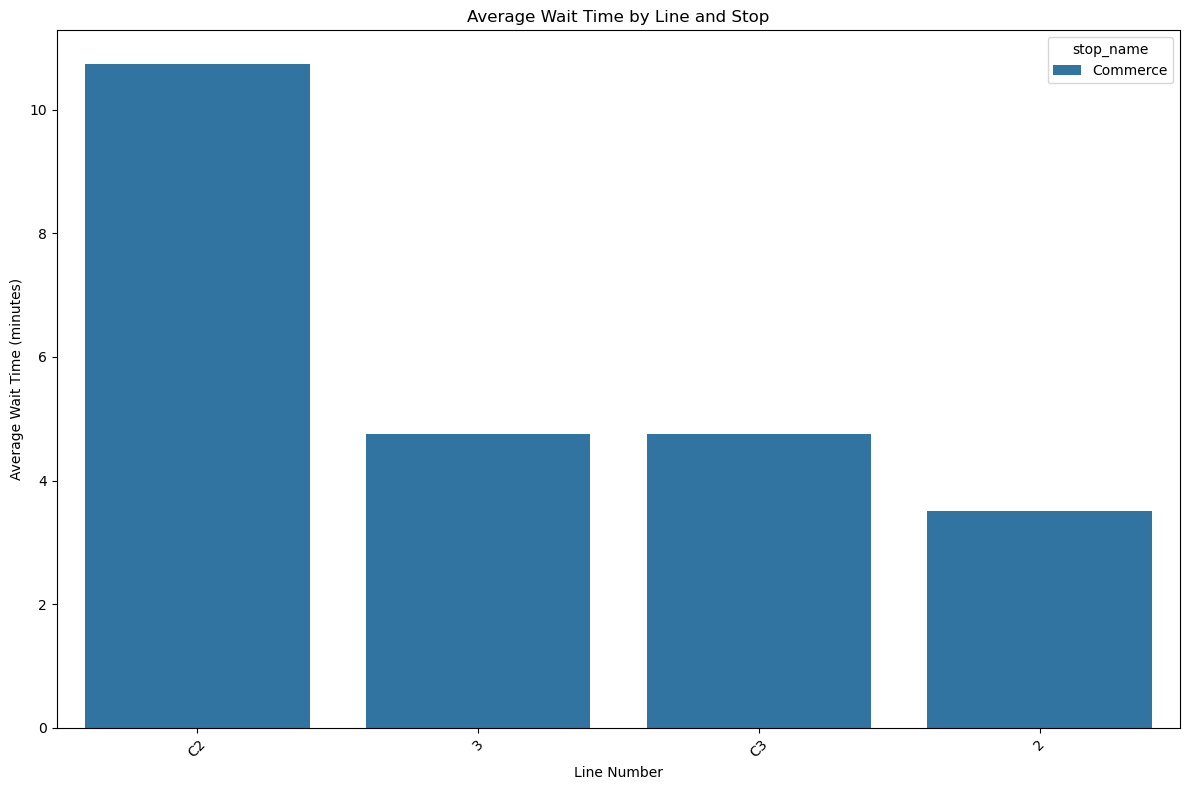

In [5]:
# Calculate average wait time by line and stop
print("Analyzing average wait times by line and stop...")

# Filter out rows with null wait times
df_valid = df.dropna(subset=['wait_time_minutes'])

# Group by line and stop
avg_wait_by_line_stop = df_valid.groupby(['line_number', 'stop_name']).agg(
    avg_wait_time=('wait_time_minutes', 'mean'),
    std_wait_time=('wait_time_minutes', 'std'),
    observation_count=('wait_time_minutes', 'count')
).reset_index()

# Filter for enough observations
avg_wait_by_line_stop = avg_wait_by_line_stop[avg_wait_by_line_stop['observation_count'] > 5]

# Sort by average wait time
avg_wait_sorted = avg_wait_by_line_stop.sort_values('avg_wait_time', ascending=False)

print("\nTop 10 line-stop combinations with longest wait times:")
print(avg_wait_sorted.head(10))

# Plot average wait times by line and stop
plt.figure(figsize=(12, 8))
top_combinations = avg_wait_sorted.head(15)  # Show only top 15 for clarity
sns.barplot(x='line_number', y='avg_wait_time', hue='stop_name', data=top_combinations)
plt.title("Average Wait Time by Line and Stop")
plt.xlabel("Line Number")
plt.ylabel("Average Wait Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Batch Analysis 2: Wait Time Distribution by Time of Day

Analyzing wait time distribution by hour of day...

Average wait time by hour of day:
   hour_of_day  avg_wait_time  std_wait_time  observation_count
0           14       7.857143       5.771709                 70


/tmp/ipykernel_665/892906207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['hour_of_day'] = df_valid['timestamp'].dt.hour


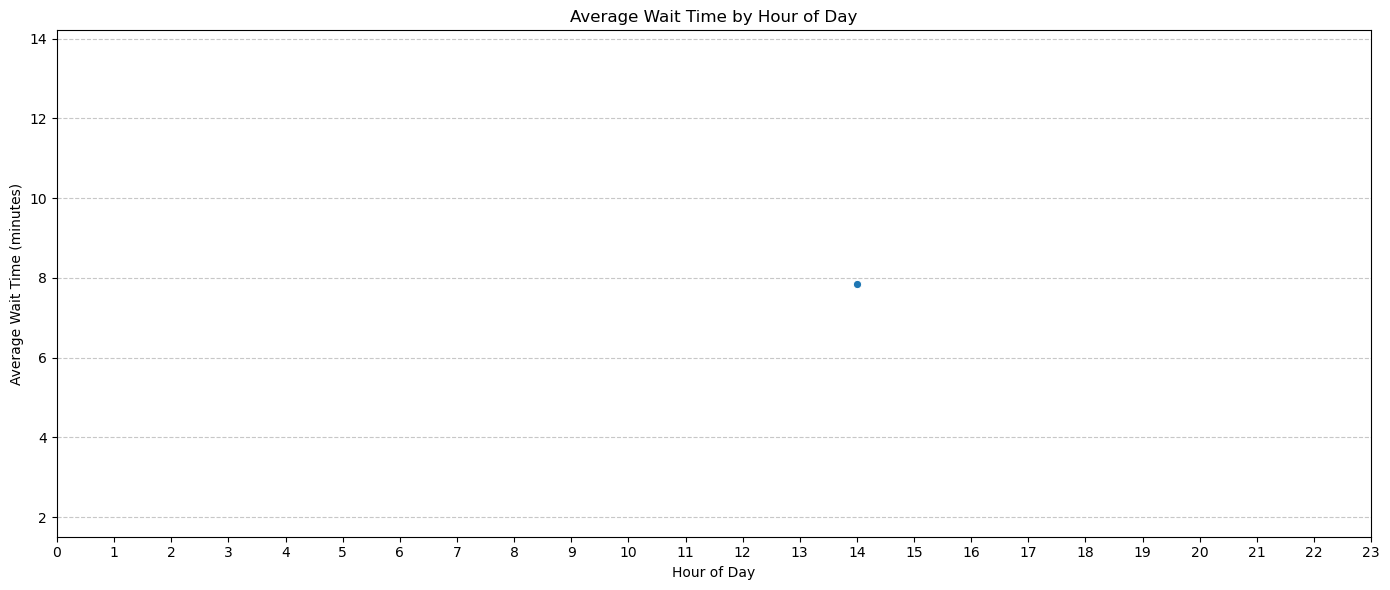

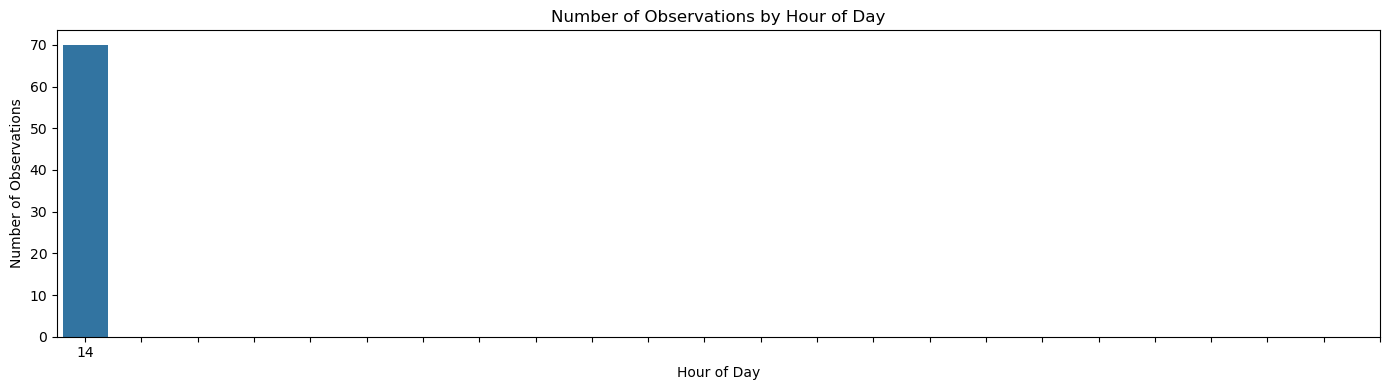

In [6]:
# Extract hour from timestamp
print("Analyzing wait time distribution by hour of day...")
df_valid['hour_of_day'] = df_valid['timestamp'].dt.hour

# Calculate average wait time by hour
avg_wait_by_hour = df_valid.groupby('hour_of_day').agg(
    avg_wait_time=('wait_time_minutes', 'mean'),
    std_wait_time=('wait_time_minutes', 'std'),
    observation_count=('wait_time_minutes', 'count')
).reset_index().sort_values('hour_of_day')

print("\nAverage wait time by hour of day:")
print(avg_wait_by_hour)

# Plot average wait times by hour
plt.figure(figsize=(14, 6))
sns.lineplot(x='hour_of_day', y='avg_wait_time', data=avg_wait_by_hour, marker='o', linewidth=2)

# Add error bands if we have stddev data
if not avg_wait_by_hour['std_wait_time'].isnull().all():
    plt.fill_between(
        avg_wait_by_hour["hour_of_day"],
        avg_wait_by_hour["avg_wait_time"] - avg_wait_by_hour["std_wait_time"],
        avg_wait_by_hour["avg_wait_time"] + avg_wait_by_hour["std_wait_time"],
        alpha=0.2
    )

plt.title("Average Wait Time by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Wait Time (minutes)")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Also show observation count by hour
plt.figure(figsize=(14, 4))
sns.barplot(x="hour_of_day", y="observation_count", data=avg_wait_by_hour)
plt.title("Number of Observations by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Observations")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

## 5. Wait Times by Line Across the Day

Analyzing wait times by line across the day...


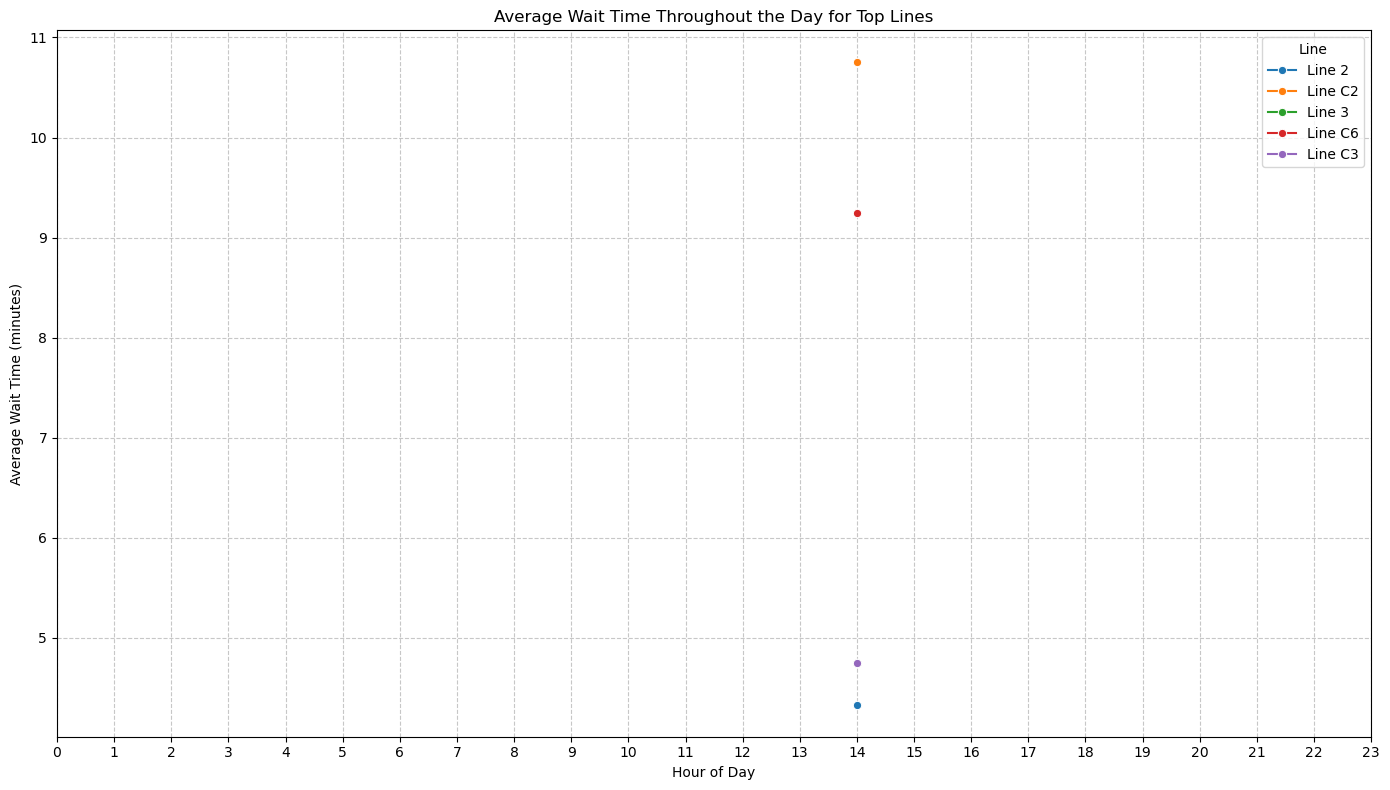

In [7]:
# Analyze wait times by line and hour
print("Analyzing wait times by line across the day...")

# Group by line and hour
avg_wait_by_line_hour = df_valid.groupby(['line_number', 'hour_of_day']).agg(
    avg_wait_time=('wait_time_minutes', 'mean'),
    observation_count=('wait_time_minutes', 'count')
).reset_index()

# Filter for enough observations
avg_wait_by_line_hour = avg_wait_by_line_hour[avg_wait_by_line_hour['observation_count'] >= 3]

# Get top 5 lines with most data points
top_lines = df_valid['line_number'].value_counts().head(5).index.tolist()
filtered_line_hour = avg_wait_by_line_hour[avg_wait_by_line_hour['line_number'].isin(top_lines)]

# Create line plot for selected important lines
plt.figure(figsize=(14, 8))
for line in top_lines:
    line_data = filtered_line_hour[filtered_line_hour['line_number'] == line]
    if not line_data.empty:
        sns.lineplot(x="hour_of_day", y="avg_wait_time", data=line_data, marker="o", label=f"Line {line}")

plt.title("Average Wait Time Throughout the Day for Top Lines")
plt.xlabel("Hour of Day")
plt.ylabel("Average Wait Time (minutes)")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Line")
plt.tight_layout()
plt.show()

## 6. Summary of Findings

=== SUMMARY OF FINDINGS ===
Total observations: 70
Average wait time: 7.9 minutes
Median wait time: 7.0 minutes
Wait time range: 0.0 to 22.0 minutes

Lines with longest average wait times:
  - Line 23: 13.0 minutes
  - Line C1: 12.2 minutes
  - Line 11: 11.0 minutes
  - Line C2: 10.8 minutes
  - Line 26: 10.5 minutes

Stops with longest average wait times:
  - Place du Cirque: 10.9 minutes
  - Commerce: 6.5 minutes
  - Chantrerie-Grandes Ecoles: 6.2 minutes

Wait times are highest at 14:00 and lowest at 14:00


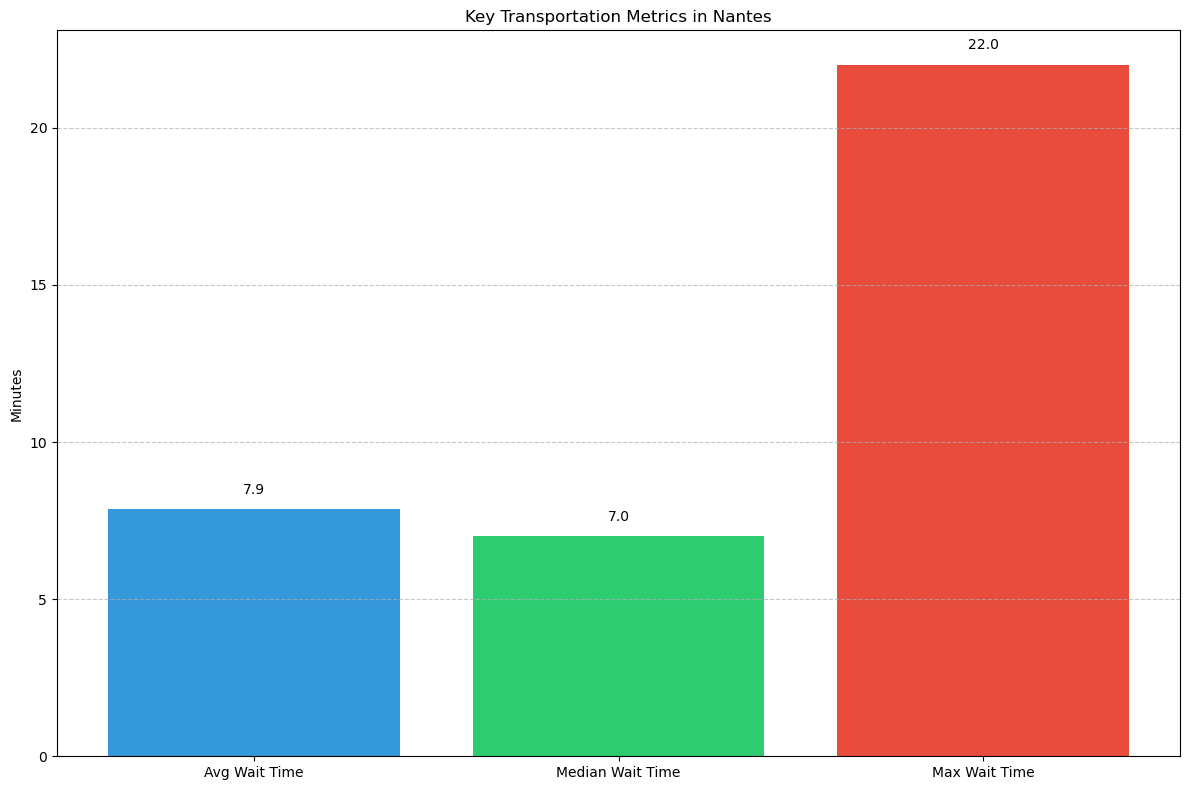

In [8]:
# Calculate overall statistics
overall_stats = {
    'total_observations': len(df_valid),
    'overall_avg_wait_time': df_valid['wait_time_minutes'].mean(),
    'median_wait_time': df_valid['wait_time_minutes'].median(),
    'min_wait_time': df_valid['wait_time_minutes'].min(),
    'max_wait_time': df_valid['wait_time_minutes'].max()
}

# Get top lines with longest average wait times
top_wait_lines = df_valid.groupby('line_number')['wait_time_minutes'].mean().sort_values(ascending=False).head(5)

# Get top stops with longest average wait times
top_wait_stops = df_valid.groupby('stop_name')['wait_time_minutes'].mean().sort_values(ascending=False).head(5)

# Get peak hour with highest wait times
peak_hour = avg_wait_by_hour.loc[avg_wait_by_hour['avg_wait_time'].idxmax(), 'hour_of_day']
low_hour = avg_wait_by_hour.loc[avg_wait_by_hour['avg_wait_time'].idxmin(), 'hour_of_day']

# Print summary
print("=== SUMMARY OF FINDINGS ===")
print(f"Total observations: {overall_stats['total_observations']}")
print(f"Average wait time: {overall_stats['overall_avg_wait_time']:.1f} minutes")
print(f"Median wait time: {overall_stats['median_wait_time']:.1f} minutes")
print(f"Wait time range: {overall_stats['min_wait_time']} to {overall_stats['max_wait_time']} minutes")
print(f"\nLines with longest average wait times:")
for line, avg_wait in top_wait_lines.items():
    print(f"  - Line {line}: {avg_wait:.1f} minutes")
print(f"\nStops with longest average wait times:")
for stop, avg_wait in top_wait_stops.items():
    print(f"  - {stop}: {avg_wait:.1f} minutes")
print(f"\nWait times are highest at {peak_hour}:00 and lowest at {low_hour}:00")

# Create a visualization summarizing the key findings
plt.figure(figsize=(12, 8))

# Key metrics visualization - bar chart with key metrics
metrics = {
    'Avg Wait Time': overall_stats['overall_avg_wait_time'],
    'Median Wait Time': overall_stats['median_wait_time'],
    'Max Wait Time': overall_stats['max_wait_time']
}
colors = ['#3498db', '#2ecc71', '#e74c3c']

plt.bar(range(len(metrics)), list(metrics.values()), align='center', color=colors)
plt.xticks(range(len(metrics)), list(metrics.keys()))
plt.title('Key Transportation Metrics in Nantes')
plt.ylabel('Minutes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.5, f'{value:.1f}', ha='center')

plt.tight_layout()
plt.show()